# exercise: sentiment analysis

Binary classification is possibly the most common type of problem in ML applications. In this one we're going to see how to build a classifier in Keras. Specifically, we will build a neural network to help us classify movie opinions as "positive/negative" based only on the textual content of the movie. It will be an example of what is currently known as sentiment analysis.

## IMDB dataset

We will use one of the datasets provided by the IMDB site (Internet Movie DataBase) formed by 50,000 highly polarized opinions (which simplifies the learning task). This set is divided in 50%/50% for training/test, and in each of them there are 50% of opinions of each type.

As with the previous dataset (MNIST) this dataset also comes with Keras, and in addition is provided pre-processed: by means of an indexed dictionary, the opinions (word sequences) have been converted into sequences of integers.

The code that loads the dataset (about 80Mb of data that will be downloaded the first time it is executed) is:

In [2]:
from tensorflow.keras.datasets import imdb
numwords=10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=numwords)

As the dictionary is tremendously large and there are many words that are rarely used, we'll be left with only the 10,000 most frequent words (something we get by means of the argument num_words = 10000 in the loading process).

If you wish, you can explore the content of the train_data and test_data variables, which are lists of opinions, where each opinion is a list of integers (encoding a sequence of words). The variables train_labels and test_labels are binary lists, where 0 indicates that the associated opinion is negative and 1 that it is positive:

In [3]:
import pandas as pd

pd.DataFrame(train_data).head()

,0
0,"[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, ..."
1,"[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463,..."
2,"[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5..."
3,"[1, 4, 2, 2, 33, 2804, 4, 2040, 432, 111, 153,..."
4,"[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 1..."


In [4]:
pd.DataFrame(train_labels).head()

,0
0,1
1,0
2,0
3,1
4,0




## Data Preprocessing

Since neural networks do not support lists of integers as input, because they are of variable length, we have to add additional pre-processing to be able to work with them. We have two options:

- Complete the shorter lists so that they're all the same length, and then convert them into tensors that will feed the input layer of the network.
- Encode the lists in One-hot to convert them into 0s and 1s vectors. Since we have a maximum of 10,000 words in our vocabulary, each opinion will be converted into a binary list of 10,000 positions indicating which words appear in the opinion. In this case, the first (dense) layer of our network would be connected with vectors of length 10,000.

We will choose this second option, which over time we will see has more advantages than the first.

The code that allows us to do this conversion is:


In [5]:
import numpy as np

def vectorize_sequences(sequences, dimension=numwords):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

We would also have to do a conversion with the labels, but since in this case they are already binary vectors, it is enough to convert them into numerical ones:


In [6]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [7]:
y_train

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

## Network Definition

As we have seen, the input data are vectors, and the labels are scalar (1s and 0s), so this is the simplest configuration possible to be worked with a neural network, and a type of network that works well with this type of problem is a simple stack of dense layers with relu activations, which in Keras are built with the instruction: layers.Dense(16, activation='relu').

In general, in all types of layers, the most common arguments you will have to use will be the number of neurons in the layer, and the type of activation these neurons will use. In the previous case we used 16 neurons, which means that this layer will use 16 dimensions to try to structure the patterns it finds in the input data according to the target function (loss) that it should optimize.

It can be intuitively interpreted that the dimension of the layer represents how much freedom the network is allowed to learn internal representations. Having more units allows you to learn more complex representations, but also increases the computational load and facilitates the memorization of patterns in the training data (which may not be relevant to the problem and may lead to an over-adjustment phenomenon).

Regarding the architecture when working with dense layers, there are two key decisions to consider:


*   How many layers to use.

*   How many units to place in each layer.


    

While there are no general rules for how to make these decisions, there are some reasons that can be learned from experience and some implicit knowledge useful for network design. For this example, without a clear justification, and only as a demonstration of the techniques we will use three intermediate layers of 16 neurons each, and a third layer that will have a single scalar output (which will represent the model's prediction). The intermediate layers will use relu as an activation function, and the final layer will use a sigmoid (which has an output in [0, 1]).

The implementation in Keras, similar to the one we already did for MNIST, is therefore

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

red = models.Sequential()
red.add(layers.Dense(4, activation='relu', input_shape=(numwords,)))
red.add(layers.Dense(4, activation='relu'))
red.add(layers.Dense(4, activation='relu'))
red.add(layers.Dense(1, activation='sigmoid'))
red.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 40004     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


In [9]:
plot_model(red, to_file='IMDBModel_plot.png', show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


Following the same pattern we saw in the previous example, we need to choose the loss function (which will be minimized) and the optimization method (which will seek to minimize that function).

Since we are facing a binary classification problem and the output of our network is a probability (provided by the sigmoid), we will use binary_crossentropy as the loss function. This is not the only viable option, we could have chosen, for example, mean_squared_error, but in this case binary_crossentropy is a better option because we are working with probabilities.

Cross entropy comes from the Information Theory field, and measures the distance between probability distributions (in this case, the distribution calculated by the predictor and the one that represents the actual distribution coming from the training data).

As an optimizer we will use rmsprop, which is usually a good choice in almost all cases. To monitor the evolution of learning we will use only one metric, accuracy.


In [10]:
red.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])

In this case we are passing all the data as strings that come predefined in Keras and work with fixed parameters, but it is also possible to adjust with more flexibility each one of them and to configure the parameters on which it depends, and even to pass you functions, either those that Keras brings or completely customized. For example:
 - we can set a new learning Rate. The lower the learning rate, the more difficult will be achieving the optimal point (so we would need to add more epochs)

In [11]:
from tensorflow.keras import optimizers

red.compile(optimizer=optimizers.RMSprop(lr=0.0001), #the default value is 0.001
            loss='binary_crossentropy',
            metrics=['binary_accuracy'])

## Model Validation

n order to monitor the metrics (accuracy) while training is taking place we need to have more data that the model does not use during the process. We will create a validation set by separating another 10,000 samples from the original set. So the situation is as follows:
- Training set: with which we will try to optimize the weights of the network so that it minimizes the loss function. In this process we use a model that depends on certain parameters that may need to be adjusted to achieve better performance.
- Validation set: with which we will measure how good is the concrete model we are training (with fixed parameters). It is something like a temporary test set. It allows to adjust these parameters to improve the performance.
- Test set: that has not been used at any moment of the previous iterations and that allows to measure in an objective way the goodness of the final model obtained.

In [12]:
from sklearn.model_selection import train_test_split

partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train, test_size=0.15)

We will then train the model on the complete training set (no validation, no test), in mini-batches of 512 samples (i.e. every 512 samples analyzed, the weights of the network are updated).

We will monitor loss and accuracy over the 10,000 samples left in the validation set. To do this, we use the validation_data argument of the fit function, which we did not use in the previous example.

As predicting the right number of iterations (epochs) can be complicated, we will prefix a high number of epochs (500) and define an early stop criterion using the EarlyStopping function (to which several decisions must be indicated, the most relevant being the monitoring criterion to be used and the number of epochs without improvement in it before stopping, called patience):

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

EarlyStopping_CallBack = [EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode='auto',
                                        baseline=None)]
entrenamiento = red.fit(partial_x_train,
                        partial_y_train,
                        callbacks=EarlyStopping_CallBack,
                        epochs=500,
                        batch_size=512,
                        validation_data=(x_val, y_val))

Train on 21250 samples, validate on 3750 samples
Epoch 1/500
21250/21250 [==============================] - 3s 156us/sample - loss: 0.6874 - binary_accuracy: 0.5425 - val_loss: 0.6810 - val_binary_accuracy: 0.5779
Epoch 2/500
21250/21250 [==============================] - 1s 41us/sample - loss: 0.6745 - binary_accuracy: 0.5805 - val_loss: 0.6687 - val_binary_accuracy: 0.5781
Epoch 3/500
21250/21250 [==============================] - 1s 37us/sample - loss: 0.6605 - binary_accuracy: 0.5871 - val_loss: 0.6550 - val_binary_accuracy: 0.5733
Epoch 4/500
21250/21250 [==============================] - 1s 37us/sample - loss: 0.6460 - binary_accuracy: 0.5989 - val_loss: 0.6418 - val_binary_accuracy: 0.5971
Epoch 5/500
21250/21250 [==============================] - 1s 39us/sample - loss: 0.6324 - binary_accuracy: 0.6261 - val_loss: 0.6299 - val_binary_accuracy: 0.6181
Epoch 6/500
21250/21250 [==============================] - 1s 38us/sample - loss: 0.6199 - binary_accuracy: 0.6491 - val_loss: 0.6

the call to fit() returns a history object, which has the following structure

In [14]:
entrenamiento_dict = entrenamiento.history
entrenamiento_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In this case, this object contains 4 entries, one for each metric being monitored during training and during validation. We can use Matplotlib to represent the training and validation losses/accuracies simultaneously:

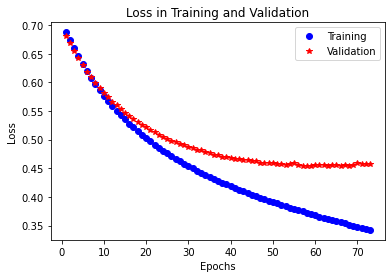

In [15]:
import matplotlib.pyplot as plt

ent_acc = entrenamiento.history['binary_accuracy']
val_acc = entrenamiento.history['val_binary_accuracy']
ent_loss = entrenamiento.history['loss']
val_loss = entrenamiento.history['val_loss']

epochs = range(1, len(ent_acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, ent_loss, 'bo', label='Training')
# r* red star
plt.plot(epochs, val_loss, 'r*', label='Validation')
plt.title('Loss in Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

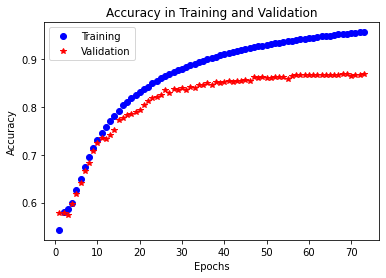

In [16]:
plt.clf()   # clear figure
acc_values = entrenamiento_dict['binary_accuracy']
val_acc_values = entrenamiento_dict['val_binary_accuracy']

plt.plot(epochs, ent_acc, 'bo', label='Training')
plt.plot(epochs, val_acc, 'r*', label='Validation')
plt.title('Accuracy in Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

These graphs show that the training loss decreases with each epoch, and that the training accuracy increases, which indicates that the optimization procedure is working properly (especially regarding the loss function). But in this case we observe that the same does not happen with the validation, which begin to worsen from the first epochs. This is a clear case of overfitting: after a few steps the system over-adjusts to the training data, and learns a representation that is specific to this data and cannot be generalised to other data.


Lets try to evaluate the model on the test data, not used until now:

In [17]:
results = red.evaluate(x_test, y_test)
results

25000/25000 [==============================] - 2s 72us/sample - loss: 0.4615 - binary_accuracy: 0.8568


[0.46148110195159914, 0.85676]

We see that the very simple approach we have made achieves a fairly high accuracy, although the current state of the art for this problem is around 95%, but working on much more elaborate networks.

## Predicción sobre datos nuevos

Having trained the network, the natural step is to use the model for something practical. We can generate new predictions about opinions to analyze whether they are positive or not using the predict method associated with the model:

In [18]:
red.predict(x_test)

array([[0.08572776],
       [0.57526094],
       [0.1722798 ],
       ...,
       [0.12737869],
       [0.09745336],
       [0.33333528]], dtype=float32)

We see that the model is very determining in some cases (reaching values like 0.99 or 0.01) but not so much in others (with values close to a medium, like 0.46)

## Proposed Work

Easy small changes:
- In the previous model we used 3 hidden layers... check the effect of increasing or decreasing this number on validation and test accuracy.
- Change the number of units in the hidden layers (8, 32, 64,...) and measure their effect.
- See what happens when you use mse as a loss function, instead of binary_crossentropy?
- See what happens when using tanh activation instead of relu?

Use Hyperas for Parameter tunning:
Select a fixed number of layers and let Hyperas select the best hyperparameters for all of them 


*   Number of neurons in each layer
*   Activation function for each layer
* Dropout value 
* optimizer
* Batch size

Is it possible to add or remove layers with hyperas?



Hyperas is not currently installed in google colab, you can install it, executing the code:


```
!pip install hyperas
```

help for using Hyperas in colab: https://nilsschlueter.de/blog/articles/keras-hyperparameter-tuning-in-google-colab-using-hyperas/

## Easy small changes

### In the previous model we used 3 hidden layers... check the effect of increasing or decreasing this number on validation and test accuracy.

In [19]:
# we try adding more hidden layers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

nn = models.Sequential([
    layers.Dense(4, activation='relu', input_shape=(numwords,)),
    layers.Dense(4, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])

EarlyStopping_CallBack = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None)]
nn.fit(partial_x_train, partial_y_train, callbacks=EarlyStopping_CallBack, epochs=500, batch_size=512, validation_data=(x_val, y_val), verbose=0)
nn.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 77us/sample - loss: 0.5460 - binary_accuracy: 0.8662


[0.5459733516216279, 0.86616]

In [20]:
# we try decreasing hidden layers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

nn = models.Sequential([
    layers.Dense(4, activation='relu', input_shape=(numwords,)),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])

EarlyStopping_CallBack = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None)]
nn.fit(partial_x_train, partial_y_train, callbacks=EarlyStopping_CallBack, epochs=500, batch_size=512, validation_data=(x_val, y_val), verbose=0)
nn.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 76us/sample - loss: 0.4621 - binary_accuracy: 0.8625


[0.46209822960853575, 0.86252]

### Change the number of units in the hidden layers (8, 32, 64,...) and measure their effect.

In [21]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

nn = models.Sequential([
    layers.Dense(8, activation='relu', input_shape=(numwords,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])

EarlyStopping_CallBack = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None)]
nn.fit(partial_x_train, partial_y_train, callbacks=EarlyStopping_CallBack, epochs=500, batch_size=512, validation_data=(x_val, y_val), verbose=0)
nn.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 83us/sample - loss: 0.4511 - binary_accuracy: 0.8672


[0.4510644646024704, 0.86724]

In [22]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

nn = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(numwords,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])

EarlyStopping_CallBack = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None)]
nn.fit(partial_x_train, partial_y_train, callbacks=EarlyStopping_CallBack, epochs=500, batch_size=512, validation_data=(x_val, y_val), verbose=0)
nn.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 72us/sample - loss: 0.4952 - binary_accuracy: 0.8691


[0.49517646633148193, 0.86912]

### See what happens when you use mse as a loss function, instead of binary_crossentropy?

In [23]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

nn = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(numwords,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['binary_accuracy'])

EarlyStopping_CallBack = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None)]
nn.fit(partial_x_train, partial_y_train, callbacks=EarlyStopping_CallBack, epochs=500, batch_size=512, validation_data=(x_val, y_val), verbose=0)
nn.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 74us/sample - loss: 0.1071 - binary_accuracy: 0.8695


[0.10712328526094556, 0.86948]

### See what happens when using tanh activation instead of relu?

In [24]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

nn = models.Sequential([
    layers.Dense(64, activation='tanh', input_shape=(numwords,)),
    layers.Dense(64, activation='tanh'),
    layers.Dense(64, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])

nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])

EarlyStopping_CallBack = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None)]
nn.fit(partial_x_train, partial_y_train, callbacks=EarlyStopping_CallBack, epochs=500, batch_size=512, validation_data=(x_val, y_val), verbose=0)
nn.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 77us/sample - loss: 0.4647 - binary_accuracy: 0.8562


[0.46474745687007907, 0.85616]

## Hyperas

In [25]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

def data():
    # we use directly global variables
    return x_train, y_train, x_test, y_test

def model(x_train, y_train, x_test, y_test):
    nn = models.Sequential([
        layers.Dense(4, activation='relu', input_shape=(numwords,)),
        layers.Dense(4, activation='relu'),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])
    EarlyStopping_CallBack = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None)]
    nn.fit(partial_x_train, partial_y_train, callbacks=EarlyStopping_CallBack, epochs=500, batch_size=512, validation_data=(x_val, y_val), verbose=0)    
    score, acc = nn.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}
    
    

In [26]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim

best_run, best_model = optim.minimize(
    model=model, 
    data=data, 
    max_evals=10, 
    algo=tpe.suggest, 
    notebook_name='SentimentAnalysisExample+exercise', 
    trials=Trials()
)

Using TensorFlow backend.


>>> Imports:
#coding=utf-8

try:
    from tensorflow.keras.datasets import imdb
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from tensorflow.keras import models
except:
    pass

try:
    from tensorflow.keras import layers
except:
    pass

try:
    from tensorflow.keras.utils import plot_model
except:
    pass

try:
    from tensorflow.keras import optimizers
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from tensorflow.keras.callbacks import EarlyStopping
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from tensorflow.keras import models
except:
    pass

try:
    from tensorflow.keras import layers
except:
    pass

try:
    from tensorflow.keras.utils import plot_model
except:
    pass

try:
    from tensorflow.keras.callbacks import EarlyStopping
except:
    pass

try:
    from tensorflow.keras import models


IndexError: list index out of range